## Table of Contents
-   [ Notes](#1)
-   [ Required Packages](#2)
- [1 - PREPARE FOR PROCESSING](#preProcess)
- [2 - Get ROI and prepare mask](#calibrate)
- [3 - Area Cutoff](#disposition)
- [4 - Process Possible Damage.](#damage)
- [PROCESS UNIT](#validate)
- [NOTES ON RESULTS](#)



<a name='1'></a>
# Notes from the Candidate.

<p><font  face="Times New Roman" size ='4'> <font color='grey' > 
I hope I had not taken the wrong approach for this exercise. I was asked to progress in the segmentation of scratches and cracks separately. I, however, have combined both to try to address the final task directly. I will be getting everything I´m asked but my progress and thoughts were focused on distinguishing cracks and scratches  from the moment I read the assingment.

<br> As I progressed through this exercise I had to address a couple of emergencies. In truth, I'm not completely satisfied as both presentation and product would have benefited from an additional work day.
<font  face="Times New Roman" size ='3'> <font color='grey' > 
<br>
I normally approach these projects building the test platform before and then interating on the algorithms. This was not the case this time.
</p>

# CameraBottom Assignment

Please find now the attached images of baseboards with superficial scratches. They look like cracks but they are not. 
*	Detect them (binarize). 
*	How could we distinguish from the previous cracks? Note that a crack makes the element be defective and a scratch makes it not. 
*	Images and scratches location in pixels:
    *	B58 BB1, right vertical element in the image, in its central part [approx. 1820x927].
    *	D59 BB2, BB5 and BB4, horizontal elements in the image, in its central part [approx. 1078x440, 1037x1088, 1000x1622].
*	Please note that first we need to emphasize them and then to detect that the element has a crack, binarizing the split.
*	Images and cracks location in pixels:
    *	B78 BB5, central horizontal element in the image, in its central part [approx. 800x920].
    *	D82 BB3, left vertical element in the image [approx. 274x1300 and along its vertical axis].
    *	D83 BB3, left vertical element in the image [approx. 318x697 and along its vertical axis].
    *	E24 BB4, lower horizontal element in la image [approx., 665x1614].
    *	E56 BB5, central horizontal element in the image, at its left part [approx. 540x1000].
    *   E70 BB1, right vertical element in the image, in its lower part [approx. 1730x1440].



<br>



###  <font color='default' > Notes on the project.

<p><font  face="Times New Roman"> <font color='grey' > The project is fairly straight forward. We are asked to differentiate scratches and real damage present in the boards. For that purpose, we are given the regions of interest to be investigated, so we will be skipping the localization part.

<br>To know what is a scratch and what might be damage, we at least must know what one them actually is. So my approach will imply separating the sets into learning sets (for both scratches and damage) and then a test set containing a mix of both of them. I will avoid overlapping learning and test sets so we could (moreless) conclude that the process works. This is a setup common for Deep learning projects, and I can't help but wonder how a DL solution will do in this scenario with enought data.
</p>



<a name='2'></a>
## - Packages and Globals

We load known packages to be used in this demostration and define some global variables.

In [5]:


import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import SupportFunctions as mySF
from sklearn.cluster import KMeans


# path to the images
TOP_IMAGES_PATH = "./camera_top"
GREY_CALIB_IMAGES_PATH = "./greyLevelCalib"


BOTTOM_IMAGES_PATH = "./camera_bottom/"


scratch_label = 100
crack_label = 101

# areas of interest for each image
area_B58_scratch = [BOTTOM_IMAGES_PATH+"B58.tif", [[1820,927]]]  #  [1780,927]
area_D59_scratch = [BOTTOM_IMAGES_PATH+"D59.tif",[[1078,440], [1037,1088], [1000,1622]] ]

area_B78_crack  = [BOTTOM_IMAGES_PATH+"B78.tif",[[800,980 ]]]  # [800,920    ]]
area_D82_crack  = [BOTTOM_IMAGES_PATH+"D82.tif",[[274,1300 ]]]
area_D83_crack  = [BOTTOM_IMAGES_PATH+"D83.tif",[[318,697 ]]]
area_E24_crack  = [BOTTOM_IMAGES_PATH+"E24.tif",[[665,1614 ]]]
area_E56_crack  = [BOTTOM_IMAGES_PATH+"E56.tif",[[540,1000 ]]]
area_E70_crack  = [BOTTOM_IMAGES_PATH+"E70.tif",[[1730,1440]]]

training_scratch_list = [area_D59_scratch]
training_crack_list = [area_B78_crack,area_D82_crack,area_E24_crack]
# image + labels,... there is an issue here, not knowing which is which in case of crack and scratches in the same board
multiAreaList = [area_D59_scratch,area_B78_crack]
test_list = [area_D83_crack,area_E56_crack,area_E70_crack,area_B58_scratch]
all_list = [area_B58_scratch,area_D59_scratch,area_B78_crack,area_D82_crack,area_D83_crack,area_E24_crack,area_E56_crack,area_E70_crack]
scratch_list = [area_B58_scratch,area_D59_scratch]
crack_list = [area_B78_crack,area_D82_crack,area_D83_crack,area_E24_crack,area_E56_crack,area_E70_crack]

# test_list = [[area_D83_crack,[crack_label]],[area_E56_crack,[crack_label]],[area_E70_crack,[crack_label]],[area_B58_scratch,[scratch_label]]]



C:\Users\luish\anaconda3\envs\Py38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\luish\anaconda3\envs\Py38\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\luish\anaconda3\envs\Py38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


<a name='preProcess'></a>
## PREPARE FOR PROCESSING


Taken from 'Top Boards' exercise

This step implies going from a Uint16 matrix to a one that will be more managable, and the image will be ready for the cleanest and fastest extraction of information.


### Possible steps to take:
<a name='ex-1'></a>
* <b>Segment the upper board.</b> This area will act as a mask under which we will be looking for damage.
Note that in this case we want to preserve all possible information as 
<br></br>


* For the topBoard check does not seem necessary to keep al the bit information of the uint16 matrix we have.
The regular uint8 should speed up the calculations without missing on information. Again, when detecting scratch and or other damage, this information will probably be much more handy.<br>Additionally, we will normallize the image to make the information more easily observable.<br><br>

* Prepare information regarding different boards, like width. Also, identify the spacing and disposition of elements regarding all 3 possible top-board variations. <br></br>


###  <font color='default' > Developer's notes.

<p><font  face="Times New Roman"> <font color='grey' > I dived into this challenge unsure on how much the levels would be marked. My expectation is that the main difference between scratches and cracks, is that cracks are simple deeper. Meaning that these areas should be darker in terms of cracks. In any case, this section serves for my own observations and I will follow up with more conclusions afterwards.

To begin I wanted to merely observe 2 boards, 1 damaged and 1 scratched.





<Figure size 432x288 with 0 Axes>

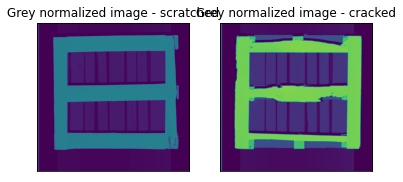

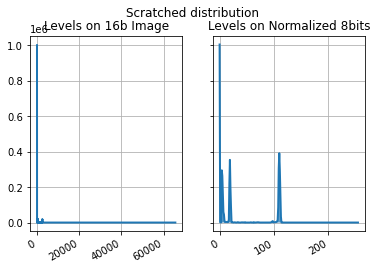

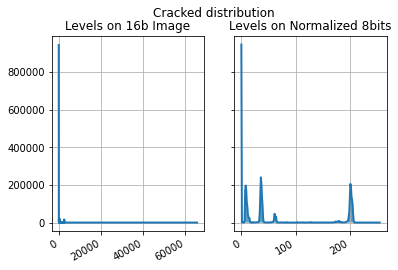

In [12]:

#   
def Convert8bAndNormalize ( image16b ):
    normalized = cv.normalize(image16b,None,0,65535,cv.NORM_MINMAX)
    return cv.convertScaleAbs(normalized,alpha=(255.0/65535.0))
    
def Convert8b (image16b):
    max_val = image16b.max()
    # return cv.convertScaleAbs(image16b,alpha=(255.0/max_val))
    return cv.convertScaleAbs(image16b,alpha=(255.0/65535.0))
    
def Normalize16b ( image16b ):
    return cv.normalize(image16b,None,0,65535,cv.NORM_MINMAX)

###############     execution part      ############

test_list = [area_D83_crack,area_E56_crack,area_E70_crack,area_B58_scratch]

# sample scratch\n",
scract_sample_filepath = area_B58_scratch[0]
scract_sample_location = area_B58_scratch[1][0]
scract_image16 = cv.imread(scract_sample_filepath, -1)

crack_sample_filepath = area_B78_crack[0]
crack_sample_location = area_B78_crack[1][0]
crack_image16 = cv.imread(crack_sample_filepath, -1)




scract_hist_values = cv.calcHist([scract_image16.flatten()],channels=[0],mask=None,histSize=[65535],ranges=[0,65535])
scract_image8bNorm = Convert8bAndNormalize ( scract_image16 )
scract_hist_values_norm = cv.calcHist([scract_image8bNorm.flatten()],channels=[0],mask=None,histSize=[256],ranges=[0,255])
crack_hist_values = cv.calcHist([crack_image16.flatten()],channels=[0],mask=None,histSize=[65535],ranges=[0,65535])
crack_image8bNorm = Convert8bAndNormalize ( crack_image16 )
crack_hist_values_norm = cv.calcHist([crack_image8bNorm.flatten()],channels=[0],mask=None,histSize=[256],ranges=[0,255])



#########  Show images and marked regions

fig = plt.figure (1)
# cosmeti display of information
# fig.set_figheight(1500)
# fig.set_figwidth(15)

fig, (ax0,ax1) = plt.subplots(1, 2)
# imageCOL = cv.drawContours(imageCOL, board, -1, (0, 255, 0),10)
ax0.get_yaxis().set_visible(False)
ax0.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax0.imshow(scract_image8bNorm)
ax0.set_title('Grey normalized image - scratched')
ax1.imshow(crack_image8bNorm)
ax1.set_title('Grey normalized image - cracked')


################# show scratch hist

fig1, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=True)

ax2.fill_between(range(0,256), min(scract_hist_values_norm[:,0]),scract_hist_values_norm[:,0],alpha=0.7)
ax2.plot(range(0,256),scract_hist_values_norm,lw = 2)

ax1.plot(range(0,65535),scract_hist_values, lw = 2)

ax1.set_title('Levels on 16b Image')
ax2.set_title('Levels on Normalized 8bits')

for ax in ax1, ax2:
    ax.grid(True)

for label in ax2.get_yticklabels():
    label.set_visible(False)

fig1.suptitle('Scratched distribution')
fig1.autofmt_xdate()

################# same for crack
fig1, (ax1, ax2) = plt.subplots(1, 2, sharex=False, sharey=True)

ax2.fill_between(range(0,256), min(crack_hist_values_norm[:,0]),crack_hist_values_norm[:,0],alpha=0.7)
ax2.plot(range(0,256),crack_hist_values_norm,lw = 2)

ax1.plot(range(0,65535),crack_hist_values, lw = 2)

ax1.set_title('Levels on 16b Image')
ax2.set_title('Levels on Normalized 8bits')

for ax in ax1, ax2:
    ax.grid(True)

for label in ax2.get_yticklabels():
    label.set_visible(False)

fig1.suptitle('Cracked distribution')
fig1.autofmt_xdate()


###  <font color='default' > Notes on greyLevels.

<p><font  face="Times New Roman"> <font color='grey' > 

I needed to check that the different camera views will have different levels for the upper board layer. Therefore, we cannot calibrate the process to work on base parameters as I did in the first exercise. I will extract the greyLevel of the top level for every image we run.

On a deep look, we can see a small bump left to the rightmost peaks. With the peak being the top layer level, the small bump has a chance of represenging either scratches or cracks on this layer. We will soon find out.

<a name ="calibrate"></a>
## Get ROI and prepare mask

First, we will use a similar process to what was used during execise 1. We will use Kmeans to cluster greyLevel distribution. The Idea is to find the cluster to the layer that is physically on top of the others, meaning, the brightest. From this we will extract the mask layer, that we will have to close morphologically to avoid wholes in the boards. This process will be normallized and converted to 8b images so we cut in processing time.

Secondly, we have aproximate coordinates of the region under observation. We will create a small cutoff of the area that we will analyze in the next section. Note that we will keep the 16 depth images as we don't want to alter any information in these cases.


###  <font color='default' > Developer Notes.
<font  face="Times New Roman"> <font color='grey' > 

As I mentioned in the TopBoard assignment, Kmeans is not implied to the best for this clustering scenario. We could use many of other available clustering algorithms to the same success. I trust the results I get by expecting 3 clusters and the speed Kmeans provides.

The idea is to isolate the topboard area to use as a mask. I remain uncertain if I this segmented area is better closed ( to avoid the wood deformities) or left as taken. In the end I have decided not to close this area as it did cover a couple of the cracks reported.



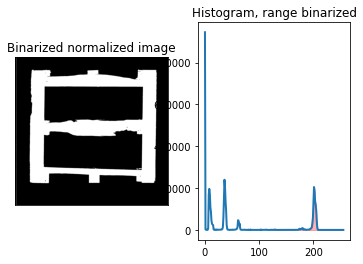

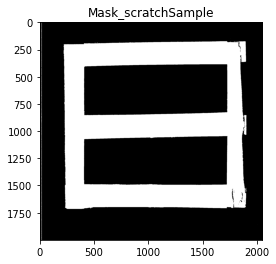

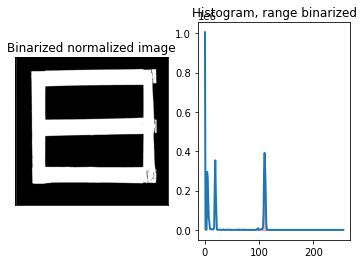

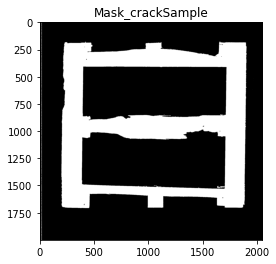

In [8]:


# will return 3 values indicating the depth of [bg, middleboards,topboards]
def getDepthLayersCenters(images, nof_clusters = 3):
    
    arr_ = []
    # cluster model
    
    scale_percent = 30
    #kmeans = blobs.KMeans(n_clusters=3, init='k-means++', random_state=0, max_iter=1)
    for ima in images:
        image8bNorm = Convert8bAndNormalize ( ima ) 
        width = int(image8bNorm.shape[1] * scale_percent / 100)
        height = int(image8bNorm.shape[0] * scale_percent / 100)
        dim = (width, height)
  
        # resize image to a 30% the original slcale
        resized = cv.resize(image8bNorm, dim)
        
        # validate not null - skipped
        arr_flatten = resized.flatten()
        kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0, max_iter=1)
        kmeans.fit(arr_flatten.reshape(-1,1)) 
        arr_.append(sorted(np.array(kmeans.cluster_centers_)))
            
    # convert from list to array    
    arr_ = np.array(arr_)
    
    nof_images = np.array(arr_).shape[0]
    nof_centers = np.array(arr_).shape[1]
    
    avr_centers = np.sum(arr_,axis=0)/nof_images

    # round and return
    return np.rint(sorted(avr_centers))


def median_value(val1, val2):
    threshold = np.rint((val1+val2)/2)
    threshold = int(threshold)
    return threshold

def getLayerByGreyRange(image, minTH, maxTH):
    
    #  th, im_th = cv.threshold(image, minTH, maxTH, cv.THRESH_BINARY)
    im_th = cv.inRange(image, minTH, maxTH)

    return im_th


def getHigherLayer(image8bNorm_, cluster_c, verbose_ = False):
    
    # top boards layer
    # threshold = th_value
    threshold = median_value(cluster_c[len(cluster_c)-2],cluster_c[len(cluster_c)-1])
    max_threshold = 255 # till whitest white

    hist_values_norm = cv.calcHist([image8bNorm_.flatten()],channels=[0],mask=None,histSize=[256],ranges=[0,255])    

    # Get binarized image of the layer
    imageTopTH = getLayerByGreyRange(image8bNorm_, threshold, max_threshold)

    if(verbose_):

        mySF.showRangeHist(imageTopTH,hist_values_norm,[threshold,256])


    return imageTopTH

###############     execution part      ############

# SELECT A CRACK AND A SCRATCH SAMPLE
scract_sample_filepath = area_B58_scratch[0]
crack_sample_filepath = area_B78_crack[0]

# GET CLUSTER LEVELS
calib_images =[scract_image16]
clusters_centers_scratch = getDepthLayersCenters(calib_images)
calib_images =[crack_image16]
clusters_centers_crack = getDepthLayersCenters(calib_images)

# This is a mask, i expect that at least scratches are included, otherwise we might have to use close/morphology operations
imageTopTH_scratch = getHigherLayer(scract_image8bNorm, clusters_centers_scratch,True)
imageTopTH_crack = getHigherLayer(crack_image8bNorm, clusters_centers_crack,True)

# close holes in the mask
imageTopTH_scratch = mySF.close(imageTopTH_scratch,3)
imageTopTH_crack = mySF.close(imageTopTH_crack,3)

# Displays
mySF.showQuickImage(imageTopTH_scratch,"Mask_scratchSample")
mySF.showQuickImage(imageTopTH_crack,"Mask_crackSample")



##  


###  <font color='default' > Finding the damage candidate areas.
<font  face="Times New Roman"> <font color='grey' > <br>

*   Calculate a quick map of gradients. Does not have to be very accurate, but must catch the irregularities present in the top layer.<br>
<br>

*   Apply an eroded version of the mask. This would eliminate the edges detected at the borders.<br>
<br>

*   Find Connected components for a minimum surface area, and get the <b>'centroid'</b> of each. This way we could proceed with the steps ahead of us. To be clear the some of the coordinates of these centers will not point to damaged areas, but these false positives will be discarded during the following process.
<br>

If a region passes the final check, we will store the centroids coordinates and maybe some information to help us match this region.
This object will be added to the list of possible canditates to be further examined later. 


<font  face="Verdana"> <font color='white' > <br>
## Area Cutoff and masks:
<br>

The code below creates small cutoff of the area we suspect contains a possible crack. This helps speeding up the processing by dealing with this separated region in isolation. Masks will also be cut in the same proportions preserving the match.





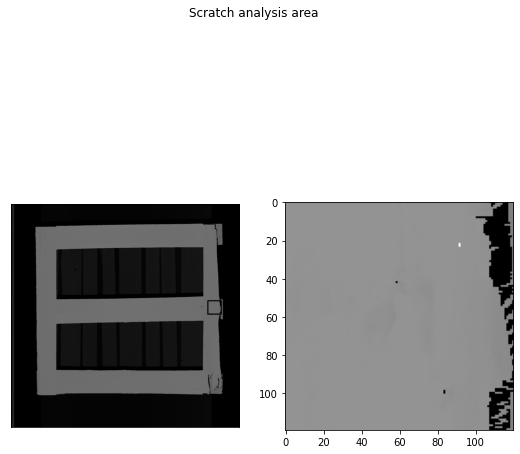

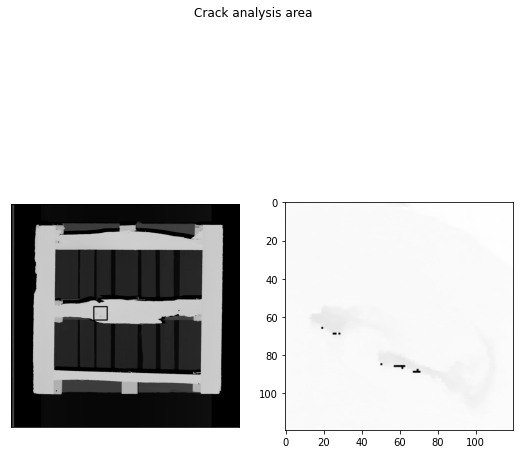

In [9]:
### Apply mast to cut off region
def applyMaskToImage(image,mask):
    copyImage = image.copy()
    if image.shape == mask.shape:
        for i  in range(mask.shape[0]):
            for j  in range(mask.shape[1]):
                if(not mask[i][j]):
                    copyImage[i][j] = 0
                    
        return copyImage
                
        # return cv.bitwise_and(image, mask)  # must then convert images to the same format (uint8 or 16)
    else: 
        print("Error: matrixes must be the same size.")
        return -1


distance = 60

marked_scratch = scract_image16.copy() 
marked_crack = crack_image16.copy() 
marked_scratch = cv.rectangle(marked_scratch, [scract_sample_location[0]-distance,scract_sample_location[1]-distance], [scract_sample_location[0]+distance,scract_sample_location[1]+distance], [150], 10)
marked_crack = cv.rectangle(marked_crack, [crack_sample_location[0]-distance,crack_sample_location[1]-distance], [crack_sample_location[0]+distance,crack_sample_location[1]+distance], [150], 10)

cutoff_scratch_mask = mySF.getImageCutoffAroundPoint(imageTopTH_scratch,scract_sample_location,distance)
cutoff_crack_mask = mySF.getImageCutoffAroundPoint(imageTopTH_crack,crack_sample_location,distance)

cutoff_scratch = mySF.getImageCutoffAroundPoint(scract_image16,scract_sample_location,distance)
cutoff_crack = mySF.getImageCutoffAroundPoint(crack_image16,crack_sample_location,distance)

# mySF.showQuickImage(cutoff_scratch_mask, "mask")
# mySF.showQuickImage(cutoff_crack_mask, "mask")

MaskApplied_scratch = applyMaskToImage(cutoff_scratch,cutoff_scratch_mask)
MaskApplied_crack = applyMaskToImage(cutoff_crack,cutoff_crack_mask)

mySF.show2ImagesSideBySide(marked_scratch,cutoff_scratch,"Scratch analysis area")
mySF.show2ImagesSideBySide(marked_crack,cutoff_crack,"Crack analysis area")






###  <font color='default' > What is damaged?
<font  face="Times New Roman"> <font color='grey' > <br>

Now begins 'the meat and potatoes' of this challenge. First, I will explain with a simple image how I saw the problem and what I expected to find. The following are representations of boards cut on the exact place where the suspected damage has appened:

<img src="PresentationResources/DamageTheory.jpg" width=1200 height=400 />
<br><br>
<font color='default' > 

#### My expectations were as follows:<br><br>
</font>
<font  face="Times New Roman"> <font color='grey' > 

*   Scracthes will be shallower than cracks. Meaning that cracks reach deeper into the board compromising the integrity of the structure, and therefore, getting labelled as 'damage'<br><br>


*   Cracks may probably present more irregular forms while (big maybe) scratches are caused by directional friction. <br>
<br>

*   A crack should have a minimun surface to be considered a risk. Example, the torn down surface created by pulling a nail off will probably not be considered a danger.

*   The main risk presented is that the board gets to thin at some section due to this damage. If is in a very sharp or a slow slope, is not as relevant as much as how deep it gets. 







###  Tests and val



Testing >> finding scratches in scratch image...


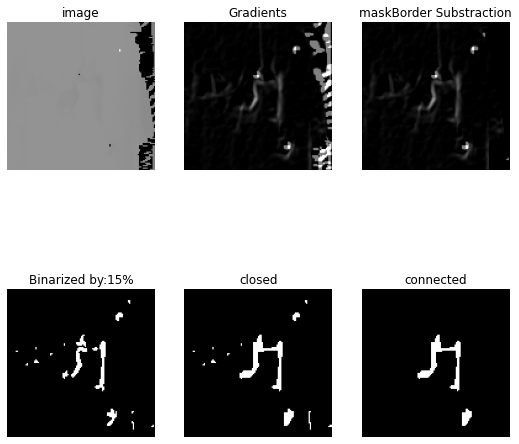

Detected :True
Testing >> finding scratches in crack image...


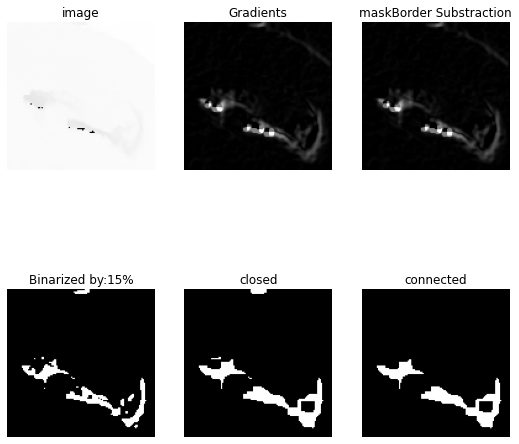

Detected :True
Testing >> finding cracks in crack image...


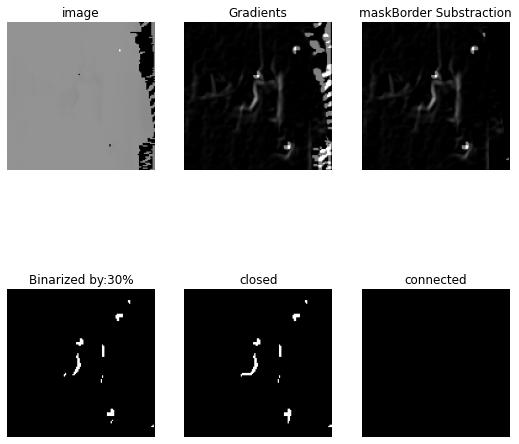

Detected :False
Testing >> finding cracks in crack image...


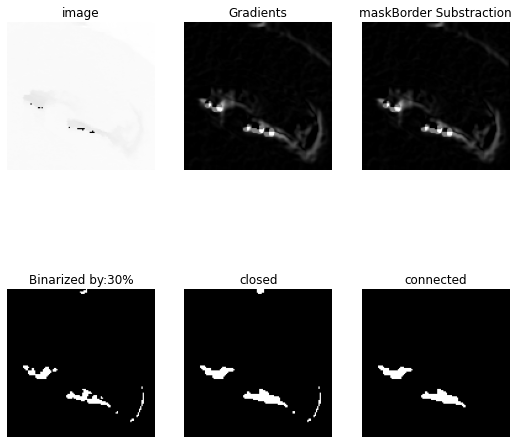

Detected :True


In [10]:


def Gradients(imageGrey,KSIZE):
    
  copyImg = imageGrey.copy()  
  copyImg = cv.GaussianBlur(copyImg, (KSIZE,KSIZE), cv.BORDER_DEFAULT )
  
  sobelx64 = cv.Sobel(imageGrey,cv.CV_16U,1,0,ksize=KSIZE)
  sobely64 = cv.Sobel(imageGrey,cv.CV_16U,0,1,ksize=KSIZE)
  combined = cv.addWeighted(sobelx64, 0.5, sobely64, 0.5, 0)
  return combined

def BinGrads(gradsImage, thPercent):
  copyImage = gradsImage.copy()
  # max_val = gradsImage.max()
  max_val = 65535 
  # copyImage = np.zeros([gradsImage[0],gradsImage[1],cv.CV_16U])
  thvalue = thPercent*(max_val)/100
  for i  in range(gradsImage.shape[0]):
      for j  in range(gradsImage.shape[1]):
          if( abs(gradsImage[i][j]) > thvalue):
              copyImage[i][j] = 65535
          else :
            copyImage[i][j] = 0  
             
  return copyImage

def substractMask(image, mask,value):
    maskCopy = mask.copy()
    maskCopy = mySF.erode(maskCopy, value)
    maskCopy = applyMaskToImage(image,maskCopy)
    return maskCopy

def keepConnectedComponents(img, min_size, connectivity=8):
    
  found = False
  
    # Find all connected ("labels")
  imgCopy = img.copy()
    # num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(
    #     img, connectivity=connectivity)
  num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(imgCopy,connectivity)
    
    # check size of all connected components (area in pixels)
  for i in range(num_labels):
        label_size = stats[i, cv.CC_STAT_AREA]
        
        # remove connected components smaller than min_size
        if label_size < min_size:
            imgCopy[labels == i] = 0
            num_labels-=1
    
    # 1 is the minimum value because the background counts
  if(num_labels > 1):
      found = True

          
  return imgCopy ,found


def DetectScratchesLevel(image, mask,th_lvl,min_size,verbose = False):
  bin_percent_th = th_lvl
  grad = Gradients(image,7)
  applyMask = substractMask(grad, mask, 10)
  bin = BinGrads(applyMask, bin_percent_th)
  close = mySF.close(bin,7)
  convert = Convert8b(close)
  connected, check = keepConnectedComponents(convert, min_size, connectivity=8)
  
  
  if verbose:
   
    fig = plt.figure(figsize=(9, 9))  
    # ax.set_xlabel("Check Cracks")
    fig.add_subplot(2, 3, 1)
    # showing image
    plt.imshow(image,cmap='gray')
    plt.axis('off')
    plt.title("image")
    
    fig.add_subplot(2, 3, 2)
    # showing image
    plt.imshow(grad,cmap='gray')
    plt.axis('off')
    plt.title("Gradients")
    
    fig.add_subplot(2, 3, 3)
    # showing image
    plt.imshow(applyMask,cmap='gray')
    plt.axis('off')
    plt.title("maskBorder Substraction")
    
    fig.add_subplot(2, 3, 4)
    # showing image
    plt.imshow(bin,cmap='gray')
    plt.axis('off')
    plt.title("Binarized by:" +str(bin_percent_th)+ "%")
    
    fig.add_subplot(2, 3, 5)
    # showing image
    plt.imshow(close,cmap='gray')
    plt.axis('off')
    plt.title("closed")
    
    
    fig.add_subplot(2, 3, 6)
    # showing image
    plt.imshow(connected,cmap='gray')
    plt.axis('off')
    plt.title("connected")
      

    plt.show()
  
  return connected, check

def DetectCracksLevel(image, mask, th_lvl,min_size,verbose = False):
  bin_percent_th = th_lvl
  
  grad = Gradients(image,7)
  applyMask = substractMask(grad, mask, 10)
  bin = BinGrads(applyMask, bin_percent_th)
  close = mySF.close(bin,7)
  convert = Convert8b(close)
  connected, check = keepConnectedComponents(convert, min_size, connectivity=8)
  
  
  if verbose:
        

    fig = plt.figure(figsize=(9, 9))  
    # ax.set_xlabel("Check Cracks")
    fig.add_subplot(2, 3, 1)
    # showing image
    plt.imshow(image,cmap='gray')
    plt.axis('off')
    plt.title("image")
    
    fig.add_subplot(2, 3, 2)
    # showing image
    plt.imshow(grad,cmap='gray')
    plt.axis('off')
    plt.title("Gradients")
    
    fig.add_subplot(2, 3, 3)
    # showing image
    plt.imshow(applyMask,cmap='gray')
    plt.axis('off')
    plt.title("maskBorder Substraction")
    
    fig.add_subplot(2, 3, 4)
    # showing image
    plt.imshow(bin,cmap='gray')
    plt.axis('off')
    plt.title("Binarized by:" +str(bin_percent_th)+ "%")
    
    fig.add_subplot(2, 3, 5)
    # showing image
    plt.imshow(close,cmap='gray')
    plt.axis('off')
    plt.title("closed")
    
    
    fig.add_subplot(2, 3, 6)
    # showing image
    plt.imshow(connected,cmap='gray')
    plt.axis('off')
    plt.title("connected")
      

    plt.show()
          
  return connected, check





############  Execurtion ##################

# gradients_scratch = Gradients(MaskApplied_scratch,7)
# gradients_crack = Gradients(MaskApplied_crack,7)


# mgBw_crack = BinGrads(gradients_crack, 15)

print("Testing >> finding scratches in scratch image..." )
FINAL_1, found = DetectScratchesLevel(MaskApplied_scratch,cutoff_scratch_mask,15,75,True)
print("Detected :"+ str(found) )
print("Testing >> finding scratches in crack image..." )
FINAL_2, found = DetectScratchesLevel(MaskApplied_crack,cutoff_crack_mask,15,75,True)
print("Detected :"+ str(found) )
print("Testing >> finding cracks in crack image..." )
FINAL_1, found = DetectCracksLevel(MaskApplied_scratch,cutoff_scratch_mask,30,75,True)
print("Detected :"+ str(found) )
print("Testing >> finding cracks in crack image..." )
FINAL_2, found = DetectCracksLevel(MaskApplied_crack,cutoff_crack_mask,30,75,True)
print("Detected :"+ str(found) )




##  TEST UNIT

Here you can run different list through the whole process described above. 
I have commented some that have been arranged previously, although my suggestion is to run 'scratches' and 'cracks' separately.

You are free to enable the verbose output, it will show you the figures we have gone through above.

As a requirement, note that there is a painted rectangle for the region where the suspected damage was located. In case that damage has been identified, a crack, it will be shown RED. Otherwise it will be green.

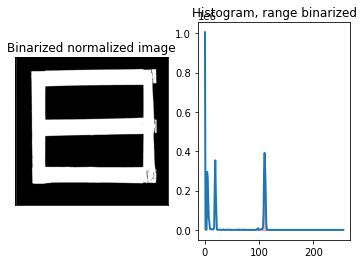

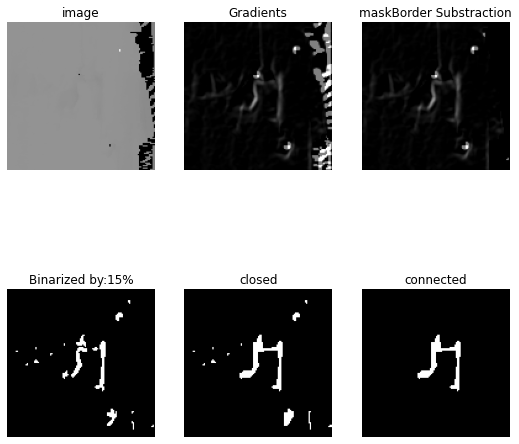

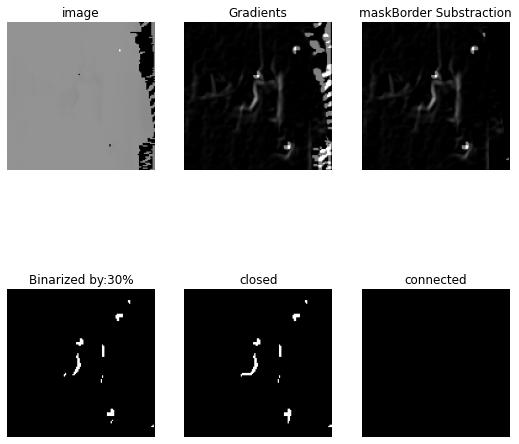

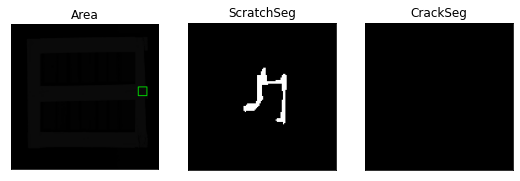

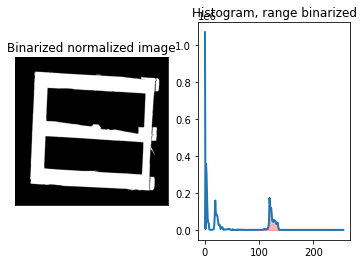

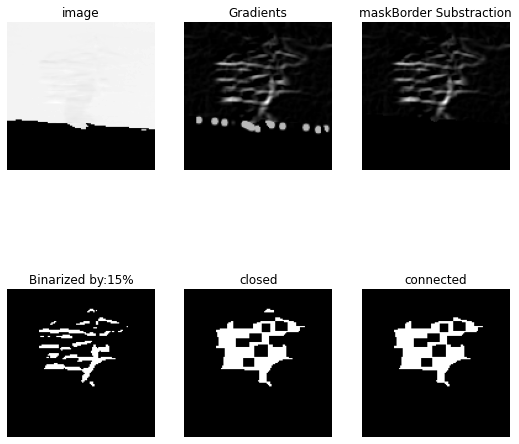

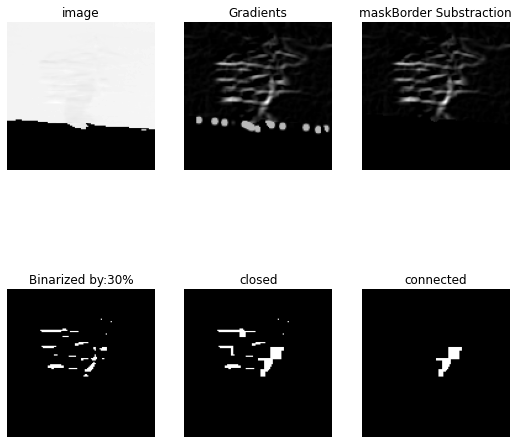

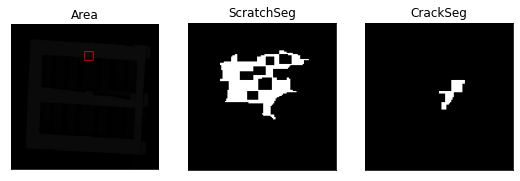

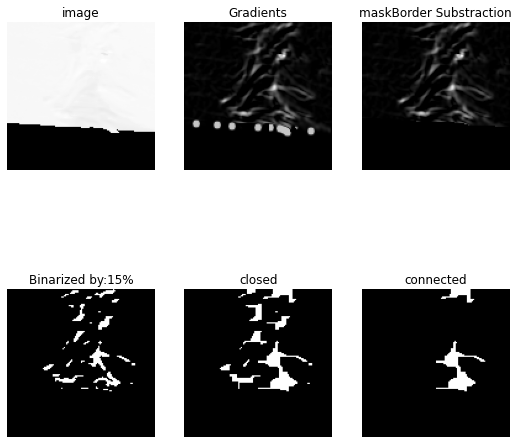

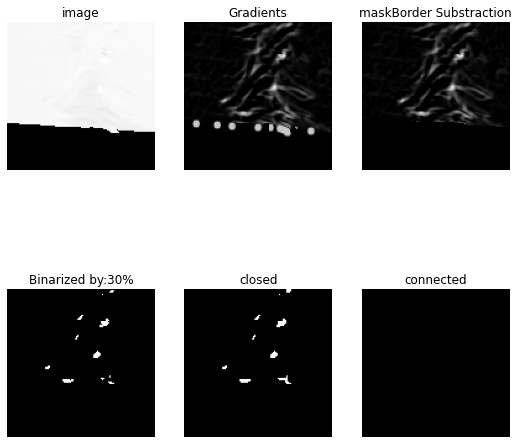

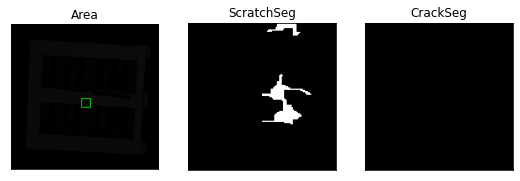

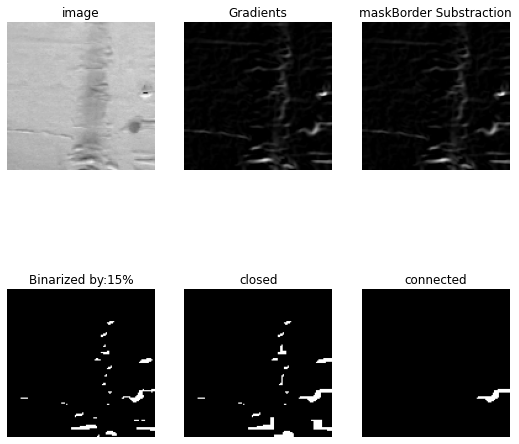

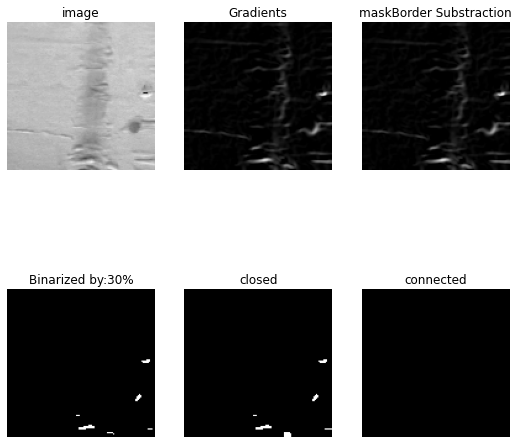

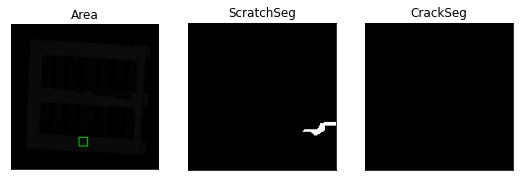

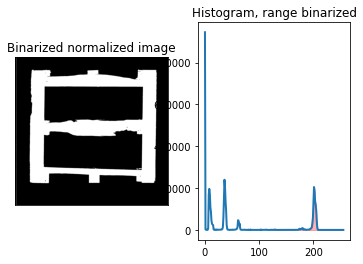

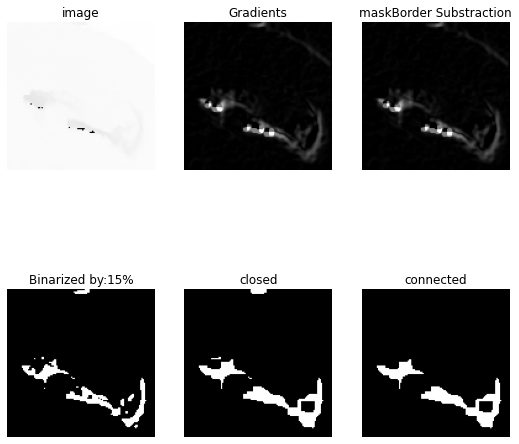

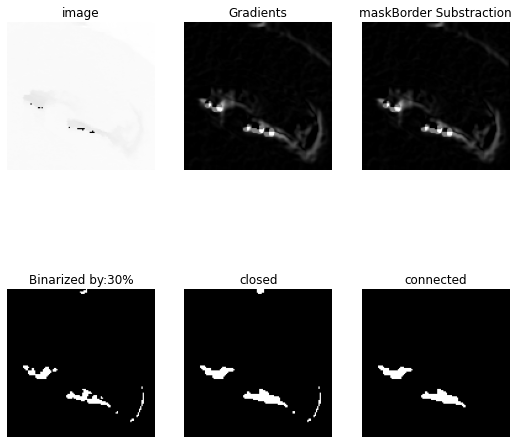

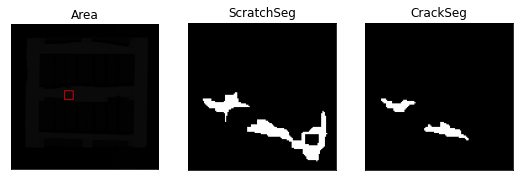

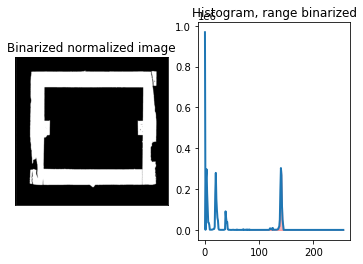

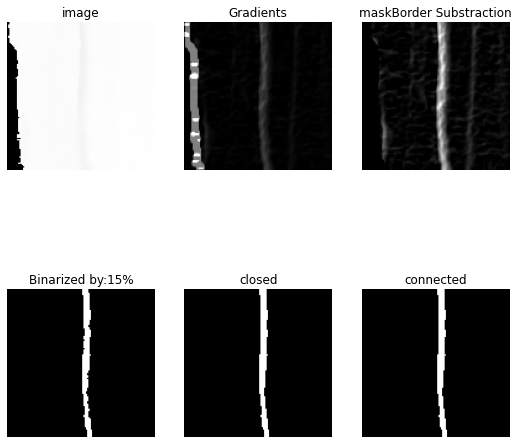

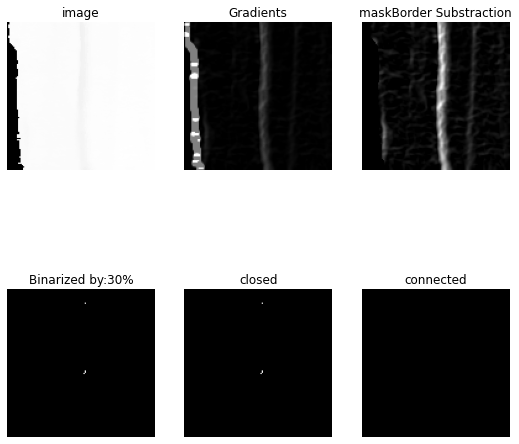

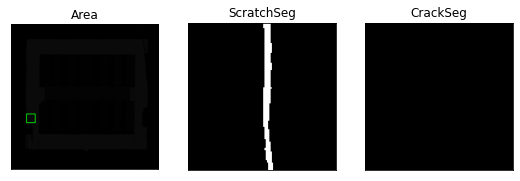

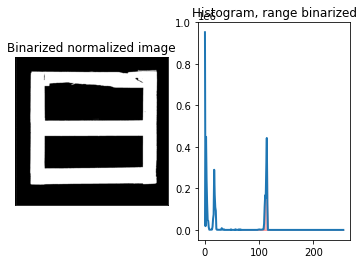

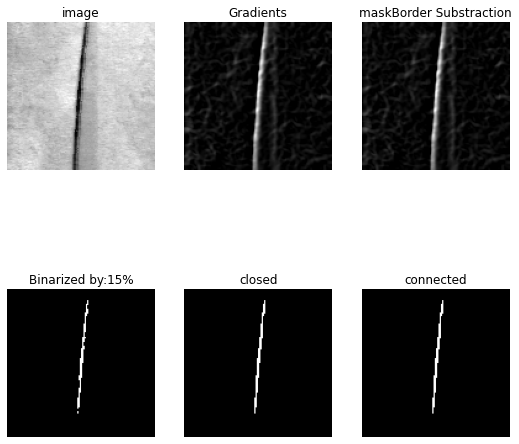

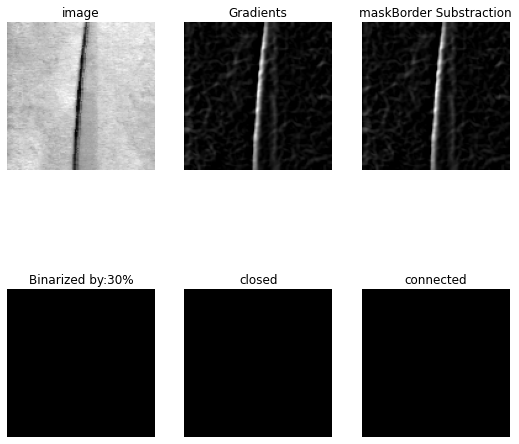

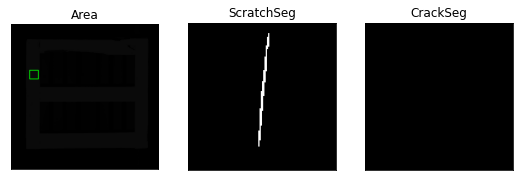

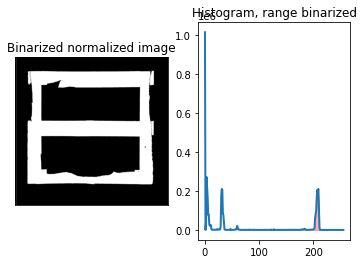

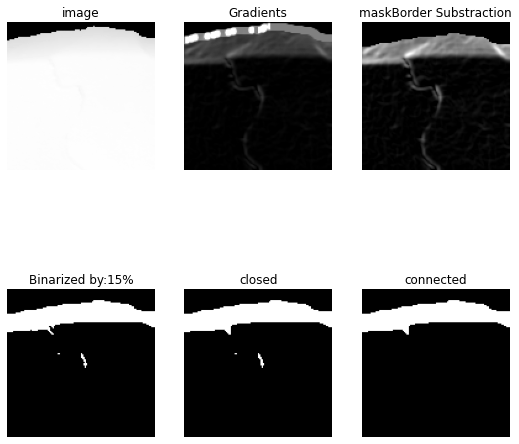

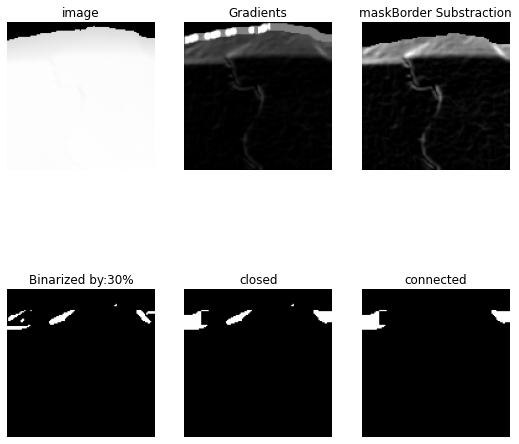

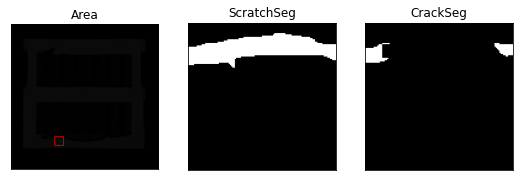

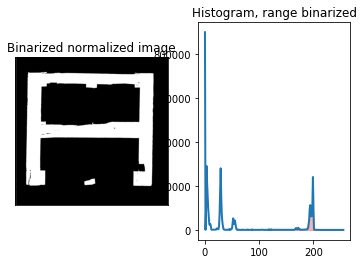

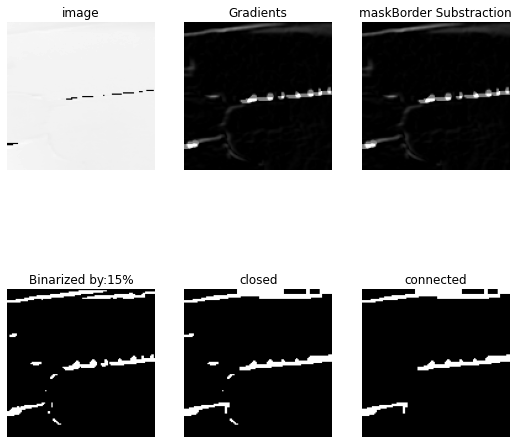

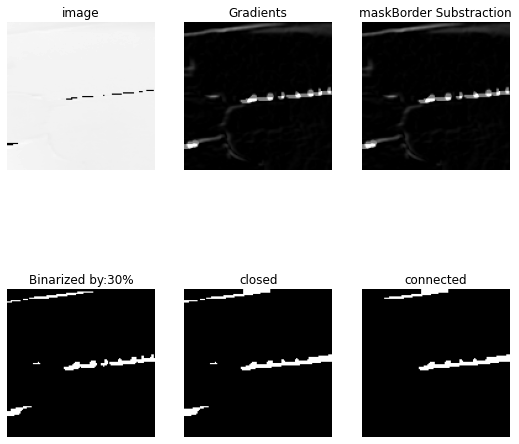

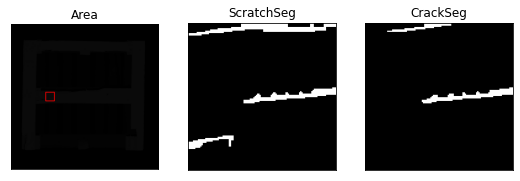

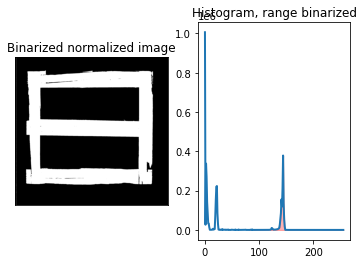

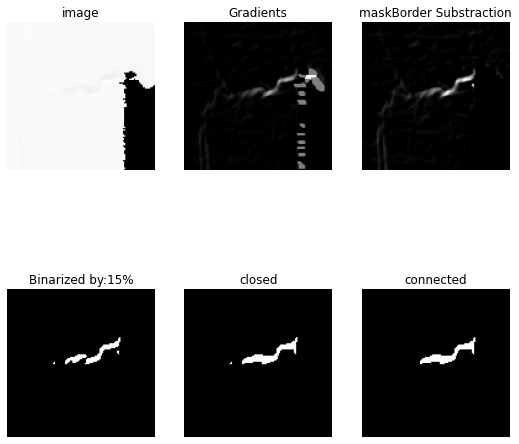

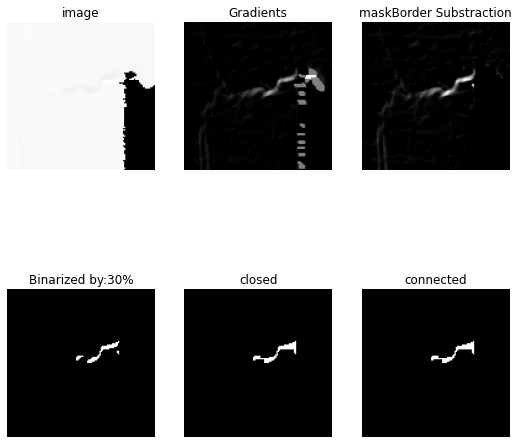

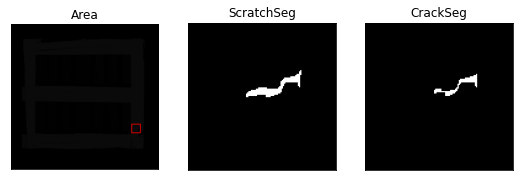

In [11]:

def labelArea(image,point,distance,damaged):
    copyImg = image.copy()
    copyImg = Convert8b(copyImg)
    colorSegment = cv.cvtColor(copyImg, cv.COLOR_GRAY2BGR)
    if(damaged):
        color = [255,0,0]
    else:
        color = [0,255,0]
    return cv.rectangle(colorSegment, [point[0]-distance,point[1]-distance], [point[0]+distance,point[1]+distance], color, 10)
    
    
VERBOSE_ = False

# enable if want to observe, but there might be plenty of information
VERBOSE_ = True  


# Globals
th_scratch = 15 
th_dmg = 30
distance = 60
min_size = 100

def runList(_list):
# for each element in the list 
    for elem in _list:
        
        image_path = elem[0]
        checking_areas = elem[1]
        
        img = cv.imread(image_path, -1)
        image8bNorm = Convert8bAndNormalize ( img )
        # prepare mask
        clusters_centers = getDepthLayersCenters([img])   # param is a list, we took the function from the other project
        top_mask = getHigherLayer(image8bNorm, clusters_centers,VERBOSE_)
        top_mask = mySF.close(top_mask,3)

        for area in checking_areas:
            
            scratched = False
            damaged = False
            segmented_crack = None
            # get the areas
            # area and shave other areas with the mask
            cutoff_img = mySF.getImageCutoffAroundPoint(img,area,distance)
            cutoff_mask = mySF.getImageCutoffAroundPoint(top_mask,area,distance)
            MaskApplied = applyMaskToImage(cutoff_img,cutoff_mask)
            
            segmented_scratch, check = DetectScratchesLevel(MaskApplied,cutoff_mask ,th_scratch,min_size,VERBOSE_)
            
            if(check):
                segmented_crack, check = DetectCracksLevel(MaskApplied,cutoff_mask,th_dmg,min_size ,VERBOSE_)
                scratched = True
                # if there is a scratch, there might be a Crack
                if(check):
                    damaged = True

            
            markedImg = labelArea(img,area,distance,damaged)
            if damaged:
                tittle_seg = "Damaged Identified"
            else:
                tittle_seg = "Just a scratch"
            
            # how far we got?
            if   not scratched:
                mySF.show2ImagesSideBySideOut(markedImg,segmented_scratch)
            else:
                mySF.show3ImagesSideBySideOut(markedImg,segmented_scratch,segmented_crack)

        
        
    #######     EXECUTION   #######          
    
    
# try these different lists
# theList = test_list
# theList = all_list
# theList = multiAreaList
# theList = scratch_list
# theList = crack_list

# worker threads are not waiting for process to finish

# print(" THE FOLLOWING SHOULD ALL BE SCRATCHES")
runList(scratch_list)
# print(" End of scratches")

# print(" THE FOLLOWING SHOULD ALL BE CRACKS")
runList(crack_list)
# print(" End of cracks")




## NOTES ON RESULTS.

I might not be the clearest, but I believe I have fulfilled all requirements.
Out of the 10 only one result is actually incorrect, although one of the segmentations (E24_crack) does not present the correct segmentation.


###  <font color='default' > TO BE IMPROVED

Finally I will make some point on what could be specially improved, most of this I could not involve myself due to time. In any case here are my cases:
<br><br>
*   <b>More dynamic thresholds.</b> Currently I set a value that separated the gradients of scratches and cracks. Seems to work for all scenarios but 2. In any case, I would have finished on a value such as this. My initial plan was to use all images to study and extract params from both scratches and cracks. But due to to time constrains, I jumped and decided to just progress directly towards the main goals.
<br><br>
*   More complex gradient detectors. I only tried the well known Sobel and Laplacian methods, there are plenty of alternatives and combinations that might have worked better. Alternatively, there is an argument to be made in using the scratched areas to try to find the cracks from that point.
<br><br>

*   It would also would have been quite a challenge to find the areas myself. This would have required a lot more experimenting and as I mentioned before, I could not use more time.
